In [1]:
"""Plots the loss of the model & performs basic evaluation - roughness dataset.
"""

'Plots the loss of the model & performs basic evaluation - roughness dataset.\n'

In [4]:
import pathlib
import torch
from typing import List, Union, Tuple
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.special import inv_boxcox
import pandas as pd
from dataset import SimulationDataset
from model import MLPRegRoughness

In [5]:
def plot_loss(
    model_name: str, train_loss: List[float], valid_loss: List[float]
) -> None:
    """Visualizes the loss data of the trained model.

    Args:
        model_name: Name of the trained model.
        train_loss: Loss data generated during training.
        valid_loss: Loss data generated during validation.
    """
    plt.figure(figsize=(12, 7))
    plt.suptitle(model_name + " loss values")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(train_loss)
    plt.plot(valid_loss)
    plt.legend(["Training Loss", "Validation Loss"])
    plt.show()

In [6]:
def txt_to_list(input_path: Union[pathlib.Path, str]) -> List[str]:
    """Loads a .txt file into a list.
    Args:
        input_path: Input path to the txt file.

    Returns:
        List containing data from the .txt file.
    """
    with open(input_path, "r") as f:
        data = f.read().splitlines()
    
    return data

In [7]:
model_name = 'lr_1_e_m4_b_8_e_1000_32_64_128_roughness'

In [8]:
TRAINED_MODEL_PATH = f'./trained_models/{model_name}.pt'
TRAIN_LOSS_PATH = f'./trained_models/{model_name}_training_loss.txt'
VALID_LOSS_PATH = f'./trained_models/{model_name}_validation_loss.txt'

In [9]:
model_name = pathlib.Path(TRAINED_MODEL_PATH).stem
train_loss= txt_to_list(TRAIN_LOSS_PATH)
valid_loss= txt_to_list(VALID_LOSS_PATH)

In [10]:
# Convert str to float & tidy up.
train_loss = [float(el) for el in train_loss]
train_loss = [round(el, 4) for el in train_loss]

valid_loss = [float(el) for el in valid_loss]
valid_loss = [round(el, 4) for el in valid_loss]

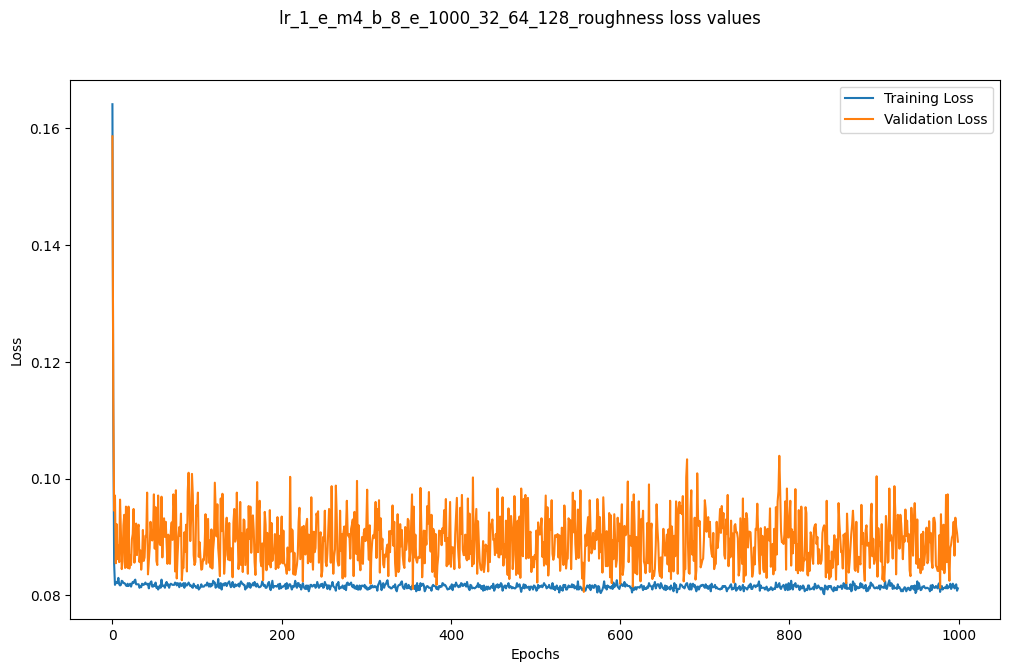

In [11]:
plot_loss(model_name, train_loss, valid_loss)

In [12]:
TRAINED_STATE_DICT_PATH = f'./trained_models/{model_name}_state_dict'

In [13]:
# Set the device & clean the memory.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
torch.cuda.empty_cache()

Device:  cuda:0


In [15]:
# Load the trained model state dictionary.
model = MLPRegRoughness()
model.load_state_dict(torch.load(TRAINED_STATE_DICT_PATH))

/tmp/ipykernel_398300/3511706311.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(TRAINED_STATE_DICT_PATH))


<All keys matched successfully>

In [16]:
# Load test dataset.
batch_size = 8
dataset_path = "./data/dataset_roughness_test.csv"
features = ["Ra", "Rz", "Rsk", "Rku", "RSm", "Rt"]
labels = ["F"]

test_dataset = SimulationDataset(dataset_path, features, labels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [25]:
# Pre - normalization min and max values of output variables. 
f_min = 69.33787637
f_max = 384.2596778

In [22]:
# Evaluate the model.
f_preds = []
f_actuals = []
for batch_features, batch_labels in test_dataloader:
    outputs = model(batch_features)
    predicted_labels = outputs.detach().numpy()

    for i in range(len(batch_features)):
        features = batch_features[i]
        labels = batch_labels[i]
        predicted = predicted_labels[i]
      
        f_pred = predicted[0]
        f_actual = labels.numpy()[0]

        f_preds.append(f_pred)
        f_actuals.append(f_actual)

In [23]:
f_preds = np.array(f_preds)
f_actuals = np.array(f_actuals)

In [26]:
# Scale the predictions and ground truth labels back to nominal range.
f_preds = f_preds * (f_max - f_min) + f_min
f_actuals = f_actuals * (f_max - f_min) + f_min

In [27]:
generalization_errors = []

for i in range(len(f_preds)):

        f_pred = f_preds[i]
        f_actual = f_actuals[i]
    
        print("Predicted F:,", f_pred)
        print("Actual F:,", f_actual)

        generalization_error = round(abs(f_pred - f_actual), 4)
        print('Error:', generalization_error)
        generalization_errors.append(generalization_error)

        print("------------------")

Predicted F:, 187.62039
Actual F:, 221.92227
Error: 34.3019
------------------
Predicted F:, 187.4212
Actual F:, 240.075
Error: 52.6538
------------------
Predicted F:, 184.36781
Actual F:, 224.23236
Error: 39.8645
------------------
Predicted F:, 193.12726
Actual F:, 211.43471
Error: 18.3074
------------------
Predicted F:, 181.10971
Actual F:, 138.01093
Error: 43.0988
------------------
Predicted F:, 189.80026
Actual F:, 238.51234
Error: 48.7121
------------------
Predicted F:, 183.14935
Actual F:, 138.01093
Error: 45.1384
------------------
Predicted F:, 177.97386
Actual F:, 69.337875
Error: 108.636
------------------
Predicted F:, 202.20224
Actual F:, 361.55615
Error: 159.3539
------------------
Predicted F:, 181.41676
Actual F:, 105.16026
Error: 76.2565
------------------
Predicted F:, 184.38052
Actual F:, 72.0522
Error: 112.3283
------------------
Predicted F:, 199.26245
Actual F:, 174.10962
Error: 25.1528
------------------
Predicted F:, 183.89601
Actual F:, 141.15451
Error: 42.

In [28]:
generalization_errors = np.array(generalization_errors)
mae = np.sum(generalization_errors / np.shape(generalization_errors)[0])

In [29]:
print('MAE:', np.round(mae, 4))

MAE: 70.6981
